In [211]:
import warnings
warnings.filterwarnings('ignore')
    
import arviz as az
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from gala.units import UnitSystem
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
from tqdm.notebook import tqdm
import astropy.table as at
from aesara_theano_fallback import tensor as tt
import exoplanet.units as xu
import json
import corner
import pandas as pd

from yellowcard.model_pymc3 import TimingArgumentModelPymc3

In [2]:
plt.rcParams.update({"text.usetex":False})

In [3]:
usys = UnitSystem(1e12*u.Msun, u.kpc, u.Gyr, u.radian)

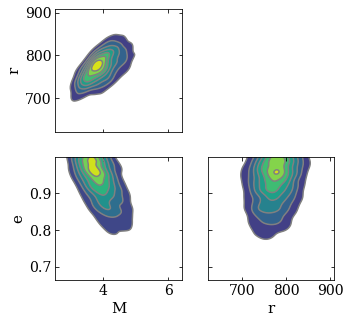

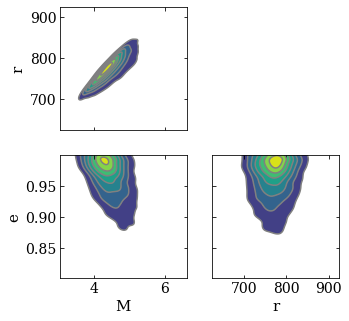

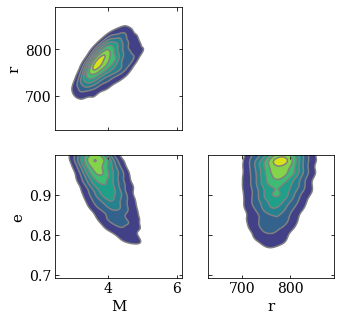

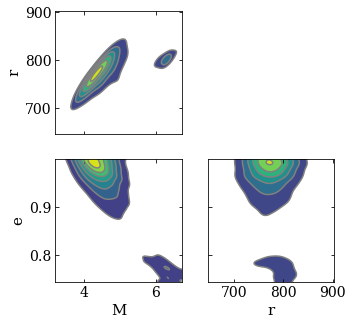

In [177]:
modelChoices = ["vdm2012","fiducial2021"]
include_vTravel = [True, False]

for mod in modelChoices:
    for incl in include_vTravel:
        data = az.from_json(f"../pymc3-data/{mod}_vTravel_{incl}.json")
        az.plot_pair(data, 
                     kind='kde',
                     show=True,
                     var_names=['M', 'r','e'],
                     figsize=(5,5))

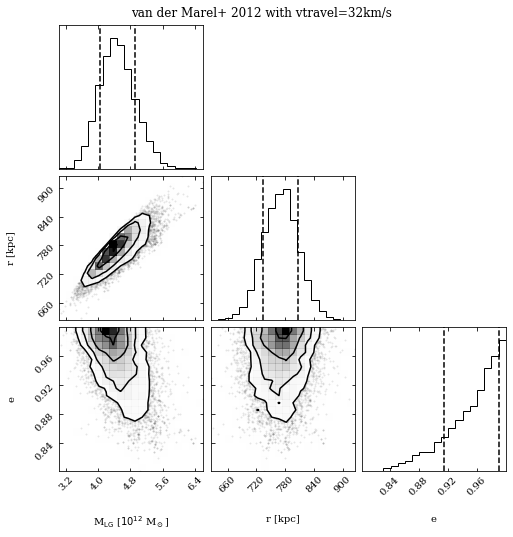

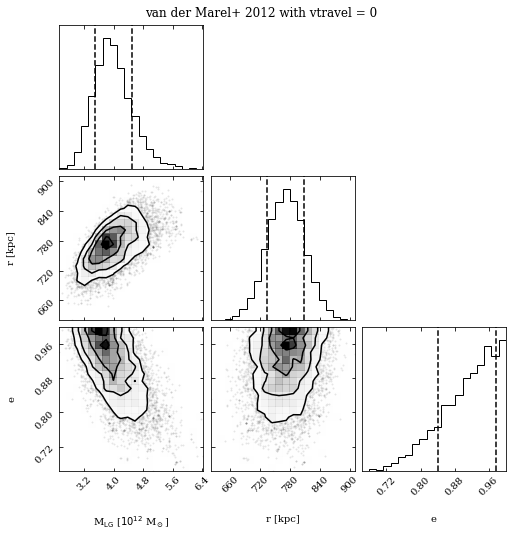

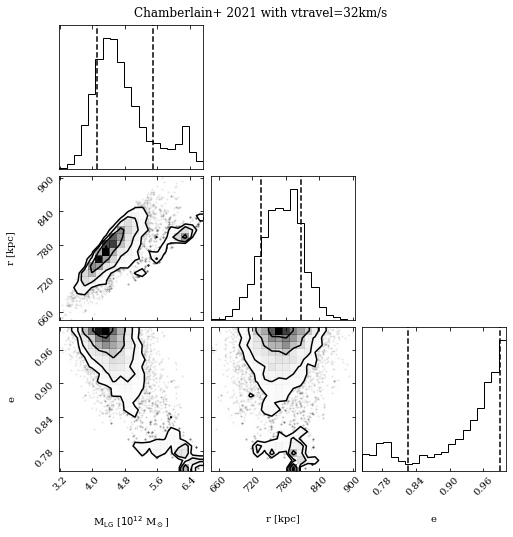

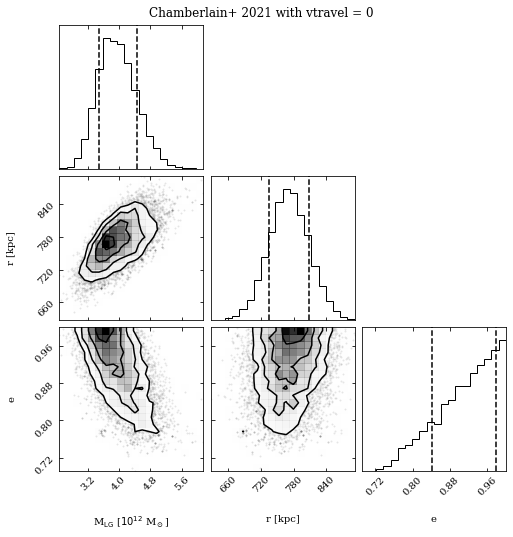

In [190]:
modelChoices = ["vdm2012","fiducial2021"]
label_model = ["van der Marel+ 2012","Chamberlain+ 2021"]
include_vTravel = [False, True]
label_vtravel = ["with vtravel=32km/s","with vtravel = 0"]

for mod,name in zip(modelChoices,label_model):
    for incl,vname in zip(include_vTravel,label_vtravel):
        data = az.from_json(f"../pymc3-data/{mod}_vTravel_{incl}.json")
        howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e"]])
        fig = corner.corner(howdy.T,
              quantiles=(0.16, 0.84),
              labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r [kpc]","e"]);
        fig.suptitle(f'{name} {vname}')
        fig.savefig(f'../plots/{mod}_vtravel_{incl}.png',dpi=300)





In [198]:
np.asarray((data.posterior['M']).mean())

array(3.99224587)

In [227]:
# get those means bby!!
# ---------------------

modelChoices = ["vdm2012","fiducial2021"]
vtravels = np.array([20,25,30,35,40,45,50,55,60,65,70,75]) 

means = {}

for mod in modelChoices:
    means[mod]={}
    
    for vs in vtravels:
        data = az.from_json(f"../pymc3-data/{mod}_vtravel_{vs}.json")
        means[mod]['vtravel'] = vs
        
        for param in ["M","r","e"]:
            means[label][param] = np.asarray((data.posterior[param]).mean())



In [231]:
pd.DataFrame(means)


,vdm2012,vdm2012_vtravel,fiducial2021,fiducial2021_vtravel
M,4.486908543446605,3.9922458681043405,4.752448833488872,3.9602741873255134
r,770.1206518089817,771.5099513182114,773.1266563836878,770.8791668430417
e,0.9543921906941019,0.9103022352378768,0.9237713034214088,0.9128649143218097


In [6]:
# dataset = "vdm2012"
# vtrav_bool = True

# data = az.from_json(f"../pymc3-data/{dataset}_vTravel_{vtrav_bool}.json")
# data

In [5]:
# dataset = "vdm2012"
# vtrav_bool = True

# data = az.from_json(f"../pymc3-data/{dataset}_vTravel_{vtrav_bool}.json")
        
# az.plot_pair(data, 
#              kind='kde',
#              show=True,
#              var_names=['M', 'r', 'e'],
#              figsize=(5,5))